# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import time
import progressbar as pb
from custom_modules.helper_functions import *

# Assisting Functions

In [2]:
def load_mfdata(country_groups, options_code):
    """
    Load mutual fund returns data.
    
    Parameters
    ----------
    country_groups : sequence of str
        Country group codes to append to filenames for reading
    options_code : str
        A code that indicates from which folder to load the data. This
        string encodes options parameters that were selected during the
        refinement of the mutual fund data.
    
    Returns
    -------
    df_return : DataFrame
        The loaded and formatted data to be read.
    
    """
    
    # Declare the start and end of the filenames to be loaded.
    f_base = (
        "..\\Data\\Refined Data\\Mutual Funds\\{}\\mf_".format(options_code)
    )
    f_end = ".csv"

    # Concatenate all country group DataFrames together in the selected
    # folder.
    df_return = pd.concat([pd.read_csv(f_base+country_code+f_end,
                                       parse_dates=["date"])
                           for country_code in country_groups],
                          ignore_index=True)
                                                                                  
    return df_return

In [3]:
def beta_hists(df_betas):
    """
    Display histograms of all factor beta distributions for a given
    table of beta values.
    
    Parameters
    ----------
    df_betas : DataFrame
        The table of beta values to be plotted.
    """
    
    for i in df_betas.columns[:6]:
        print(i)
        plt.hist(df_betas[i], bins=100,
                 range=df_betas[i].quantile([0.001, 0.999]))
        plt.show()

# Load Data

In [4]:
# Define country group strings and options code
country_groups = ["lux", "kor", "usa", "can-chn-jpn", "irl-bra", "gbr-fra-ind",
                  "esp-tha-aus-zaf-mex-aut-che", "other"]

options_code = "eq-strict_local"

In [5]:
# TODO: Eliminate missing gross returns?
# Mutual Fund data
df_mf = load_mfdata(country_groups, options_code)

In [15]:
df_mf.ret_gross_m.count()

5440786

In [16]:
df_mf["year"] = df_mf.date.dt.year

In [18]:
x = df_mf.groupby("year").dom_country.nunique()

In [29]:
x[2021] = 54

In [25]:
x = x[x.index >= 1983]

Text(0.5, 0, 'Year')

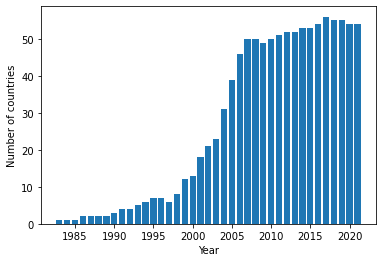

In [30]:
plt.bar(x.index, x.values)
plt.ylabel("Number of countries")
plt.xlabel("Year")

In [7]:
fview(df_mf.groupby("yearmonth").fundid.nunique())

yearmonth
1973007        1
1973008        2
1973009        2
1973010        3
1973011        3
1973012        3
1974001        3
1974002        3
1974003        3
1974004        3
1974005        3
1974006        4
1974007        4
1974008        4
1974009        4
1974010        4
1974011        4
1974012        4
1975001        6
1975002        7
1975003       13
1975004       16
1975005       20
1975006       34
1975007       46
1975008       53
1975009       77
1975010      100
1975011      106
1975012      167
1976001      201
1976002      202
1976003      203
1976004      203
1976005      204
1976006      205
1976007      206
1976008      207
1976009      209
1976010      212
1976011      215
1976012      217
1977001      219
1977002      220
1977003      220
1977004      221
1977005      221
1977006      221
1977007      221
1977008      222
1977009      222
1977010      222
1977011      224
1977012      226
1978001      226
1978002      227
1978003      227
1978004      227
1978

In [23]:
fview(df_mf.groupby("yearmonth").dom_country.unique())

yearmonth
1973007                                                [USA]
1973008                                                [USA]
1973009                                                [USA]
1973010                                                [USA]
1973011                                                [USA]
1973012                                                [USA]
1974001                                                [USA]
1974002                                                [USA]
1974003                                                [USA]
1974004                                                [USA]
1974005                                                [USA]
1974006                                                [USA]
1974007                                                [USA]
1974008                                                [USA]
1974009                                                [USA]
1974010                                                [USA]
1974011       

In [83]:
# Currency factor data
df_crfactors = pd.read_csv("..\\Data\\Refined Data\\Currencies\\curr_factors.csv",
                          parse_dates=[0])

In [84]:
# World equity factor data
df_eqfactors = pd.read_csv("..\\Data\\Refined Data\\Equity Factors\\ff4.csv",
                          parse_dates=[0])

In [85]:
# Combine both sets of factor returns into several complete factor
# DataFrames.
df_factors_lrv11 = (
    df_eqfactors.merge(df_crfactors.loc[:,["date", "hml_fx", "rx"]],
                       on="date", how="left")
)

df_factors_lrv11net = (
    df_eqfactors.merge(df_crfactors.loc[:,["date", "hml_fx_net", "rx_net"]],
                       on="date", how="left")
)

df_factors_v18 = (
    df_eqfactors.merge(df_crfactors.loc[:,["date", "carry", "dollar"]],
                       on="date", how="left")
)

# Prepare mutual funds data

In [9]:
#< ----20 chars---- >< ----20 chars---- >< ----20 chars---- ><-11chars->
#< ----20 chars---- >< ----20 chars---- >< ----20 chars---- >< ---18 chars--- >
def mf_prep(df_mf_in, df_rf, return_column="ret_gross_m"):
    """
    Subtract the risk-free rate from the mutual fund returns and isolate
    the requested returns column.
        
    Parameters
    ----------
    df_mf_in : DataFrame
        A DataFrame with dates and mutual funds returns in the columns.
    df_rf : DataFrame
        A DataFrame containing dates and risk-free rates on those dates.
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    
    Returns
    -------
    df_out : DataFrame
        Transformed mutual fund returns.
    """ 
    
    # Combine the data.
    df_mf = df_mf_in.merge(df_rf, on="date")
    
    # Subtract the risk-free rate
    df_mf["ret"] = df_mf[return_column]-df_mf.rf
    
    # Pivot to wide-form
    
    return df_mf.loc[:, ["date", "ret", ""]]

# Beta Regressions

In [26]:
def get_betas(df_fund, fundid, df_factors, return_column="ret_gross_m",
              min_obs=24, betas_only=False):
    """
    Calculate the coefficients of a regression of a single mutual fund's
    returns on factor returns.
        
    Parameters
    ----------
    df_fund : DataFrame
        A DataFrame with dates in the index and mutual funds returns in
        the columns.
    fundid : str
        The fundid of the mutual fund for which betas should be
        calculated.
    df_factors : DataFrame
        A DataFrame containing dates and a set of factor returns on
        those dates, where each column gives returns of a different
        factor
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    min_obs : int, default 24
        The minimum number of nonmissing observations of returns
        required for a beta value to be calculated.
    betas_only : bool, default False
        If True, only the beta parameters will be returned. If false,
        additional regression information will be returned alongside
        the betas.
    
    Returns
    -------
    betas_out : sequence of float
        An array containing the regression betas.
    
    """       
    # Combine the exogenous and endogenous time-series into one matrix
    # so that rows where any variable is missing can be dropped.
    dmatrix = (
        pd.concat([df_fund.loc[:, fundid], df_factors], axis=1)
          .dropna(how="any")
    )
    
    # If there are not enough overlapping non-missing observations,
    # return a null result.
    if dmatrix.index.size < min_obs:
        return np.array([])
    
    exog = dmatrix[fundid]
    endog = sm.add_constant(dmatrix.loc[:, df_factors.columns])
    
    # Perform OLS regression and return the betas
    ols_results = sm.OLS(exog, endog).fit()
    
    betas_out = ols_results.params.values[1:]
    if not betas_only:
        # Trying to take the r-squared of a series with constant
        # exogenous variable results in a warning. Avoid this by setting
        # r-squared to nan in this case.
        if exog.std() == 0:
            r_squared = np.nan
        else:
            r_squared = ols_results.rsquared
            
        betas_out = np.concatenate([betas_out, [r_squared,
                                   dmatrix.index.size]])
    return betas_out

In [24]:
def beta_table(df_mf_in, df_factors_in, return_column="ret_gross_m", min_obs=24,
               betas_only=False, loadingbar=False, load=True, save=True,
               save_folder=options_code):
    """
    Build a table of the time-series regression coefficients of mutual
    fund returns on factor returns.
        
    Parameters
    ----------
    df_mf_in : DataFrame
        A DataFrame containing dates and mutual funds' returns on those
        dates.
    df_factors_in : DataFrame
        A DataFrame containing dates and a set of factor returns on
        those dates, where each column gives returns of a different
        factor
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    min_obs : int, default 24
        The minimum number of nonmissing observations of returns
        required for a beta value to be calculated.
    betas_only : bool, default False
        If True, only the beta parameters will be returned. If false,
        additional regression information will be returned alongside
        the betas.
    loadingbar : bool, default False
        If True, a loadingbar is shown run the function is being run.
    load : bool, default True
        If True, a load of the results are attempted before running the
        function.
    save : bool, default True
        If True, the results are saved to file.
    save_folder : str, default $options_code
        The folder in which to save and attempt loads of regression
        results

    
    Returns
    -------
    df_out : DataFrame
        A DataFrame of the regression betas along with additional
        regression information if desired.
    """
    if save or load:
        # Set the save directory
        save_dir = "..\\Data\\Regression Results\\{}".format(save_folder)
        
        # Check the column names of the input factors DataFrame to
        # determine the filename of potential saves
        if "hml_fx" in df_factors_in:
            filename = "lrv11_betas"
        elif "hml_fx_net" in df_factors_in:
            filename = "lrv11net_betas"
        elif "carry" in df_factors_in:
            filename = "v18_betas"
        else:
            raise ValueError("This factors DataFrame is not recognised.")
            
    if load:
        try:
            if betas_only:
                df_out = pd.read_csv("{save_dir}\\{filename}.csv"
                                     .format(save_dir=save_dir,
                                             filename=filename),
                                     index_col=0)
            else:
                df_out = pd.read_csv("{save_dir}\\{filename}.csv"
                                     .format(save_dir=save_dir,
                                             filename=filename+"_plus"),
                                     index_col=0)
            
            print("Results loaded from file.")
            
            return df_out
        except FileNotFoundError:
            pass
        
    # Intialise empty dictionary to hold regression results and to be
    # transformed later into a DataFrame.
    dict_betas = dict()
    
    # Subtract the risk-free rate from mutual fund returns
    df_mf = df_mf_in.merge(df_factors_in[["date", "rf"]], on="date")
    df_mf["ret"] = df_mf[return_column]-df_mf.rf
    
    # Transform the mutual funds DataFrame to wide form to work with the
    # beta function.
    df_mf = df_mf.pivot(index="date", columns="fundid",
                        values="ret_gross_m")
    
    
    # Set the index of the factors DataFrame if necessary
    df_factors = df_factors_in.copy().drop("rf", axis=1)
    
    if "date" in df_factors.columns:
        df_factors.set_index("date", inplace=True)
    
    
    # Loop through all mutual funds in the DataFrame and call the
    # time-series regression
    if loadingbar:
        bar = pb.ProgressBar(max_value=df_mf.columns.size)
        bar.update(0)
        
    for i in df_mf.columns: 
        asset_beta = get_betas(df_mf, i, df_factors, return_column, min_obs,
                               betas_only)

        # Only add the betas to the return dictionary if they exist
        if asset_beta.size > 0:
            dict_betas[i] = asset_beta        
        if loadingbar:
            if bar.value == bar.max_value-1:
                # The loading bars stopped updating just before 100%, so
                # this forces them to catch up.
                time.sleep(0.1)
            bar.update(bar.value+1)
    
    # Determine output DataFrame columns
    return_columns = list(df_factors.columns+"_beta")

    if not betas_only:
        return_columns = return_columns + ["r2", "n_obs"]

    # Return a new dataframe of beta values for each fund
    df_out = pd.DataFrame.from_dict(dict_betas, orient="index",
                                    columns=return_columns)
    df_out.columns.name = None
    
    if save:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if betas_only:
            df_out.to_csv("{save_dir}\\{filename}.csv"
                          .format(save_dir=save_dir, filename=filename))
        else:
            df_out.to_csv("{save_dir}\\{filename}.csv"
                          .format(save_dir=save_dir,
                                  filename=filename+"_plus"))
            
            
            df_out.drop(["r2", "n_obs"],
                        axis=1).to_csv("{save_dir}\\{filename}.csv"
                                       .format(save_dir=save_dir,
                                               filename=filename))
        
    return df_out

In [90]:
df_betas_lrv11 = beta_table(df_mf, df_factors_lrv11, loadingbar=True)

Results loaded from file.


In [22]:
df_betas_lrv11net = beta_table(df_mf, df_factors_lrv11net, loadingbar=True)

Results loaded from file.


In [23]:
df_betas_v18 = beta_table(df_mf, df_factors_v18, loadingbar=True)

Results loaded from file.


# Return Decomposition

In [86]:
df_factors_lrv11 = df_factors_lrv11.dropna(how="any")

In [94]:
df_betas_lrv11 = df_betas_lrv11.reset_index().rename(columns={"index":"fundid"})

In [95]:
df_mf_rf = df_mf[["date", "fundid", "ret_gross_m"]].merge(df_factors_lrv11[["date", "rf"]], on="date")

In [96]:
df_mf_rf["ret"] = df_mf_rf.ret_gross_m - df_mf_rf.rf
df_mf2 = df_mf_rf.drop(["ret_gross_m", "rf"], axis=1)

In [97]:
df_mf2_facret = df_mf2.merge(df_factors_lrv11.drop("rf", axis=1), on="date")

In [98]:
df_mf2_facret_betas = df_mf2_facret.merge(df_betas_lrv11, on="fundid")

In [99]:
for i in ["mkt", "smb", "hml", "wml", "hml_fx", "rx"]:
    df_mf2_facret_betas["ret_"+i] = df_mf2_facret_betas[i] * df_mf2_facret_betas[i+"_beta"]
    
df_mf2_facret_betas["alpha"] = (
    df_mf2_facret_betas.ret -
    (
        df_mf2_facret_betas.ret_mkt
        + df_mf2_facret_betas.ret_smb
        + df_mf2_facret_betas.ret_hml
        + df_mf2_facret_betas.ret_wml
        + df_mf2_facret_betas.ret_hml_fx
        + df_mf2_facret_betas.ret_rx
    )
)

In [111]:
df_mf3 = df_mf2_facret_betas.copy().dropna(subset=["ret"])

In [112]:
df_mf3[np.round(df_mf3[["ret_mkt", "ret_smb", "ret_hml", "ret_wml", "ret_hml_fx", "ret_rx", "alpha"]].sum(axis=1),4) != np.round(df_mf3.ret,4)]

,date,fundid,ret,mkt,smb,hml,wml,hml_fx,rx,mkt_beta,...,rx_beta,r2,n_obs,ret_mkt,ret_smb,ret_hml,ret_wml,ret_hml_fx,ret_rx,alpha
647,2015-05-31,FS000094EV,-1.81365,0.50,1.22,-1.12,4.29,0.454061,-1.634000,0.471621,...,-0.569519,0.587624,112.0,0.235810,-0.132357,0.030488,0.441689,0.078834,0.930594,-3.398710
711,2011-10-31,FS000094EV,1.40045,10.01,-2.13,-1.92,-1.33,3.567425,3.114072,0.471621,...,-0.569519,0.587624,112.0,4.720924,0.231082,0.052266,-0.136934,0.619379,-1.773525,-2.312742
777,2016-11-30,FS000094EW,-0.13105,1.39,0.25,4.39,-4.11,-2.112303,-2.764398,0.386925,...,-0.534647,0.482606,112.0,0.537826,-0.020814,-0.356170,-0.295782,-0.252453,1.477976,-1.221632
1884,2010-01-31,FS0000D4CS,0.86605,-3.73,2.56,-0.06,-2.26,0.903059,-0.608874,0.259574,...,-0.236670,0.568013,178.0,-0.968210,0.449430,-0.004425,-0.192599,0.153511,0.144102,1.284240
2596,2013-04-30,FSGBR04EH4,0.53455,3.02,-1.15,0.90,3.08,0.558327,1.052960,1.065138,...,-0.651672,0.817030,152.0,3.216717,-0.049906,-0.121315,0.763030,0.082085,-0.686184,-2.669876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744717,1991-04-30,FSUSA006B2,-0.17045,0.54,0.01,0.46,-0.02,-0.469119,0.310666,0.822497,...,-0.339889,0.620124,34.0,0.444149,0.005517,-0.908679,-0.012013,-0.175400,-0.105592,0.581569
5744723,1991-10-31,FSUSA006B2,0.35375,1.36,-0.25,-1.42,2.46,0.220455,-0.079367,0.822497,...,-0.339889,0.620124,34.0,1.118596,-0.137916,2.805053,1.477643,0.082426,0.026976,-5.019028
5745034,1991-06-30,FSUSA006VF,0.22885,-6.07,1.32,1.11,1.11,-3.604218,-2.398046,-0.002472,...,0.088791,0.328992,36.0,0.015006,-0.021220,-0.129252,0.096504,-0.230919,-0.212924,0.711655
5745208,1991-04-30,FSUSA006ZV,-0.74605,0.54,0.01,0.46,-0.02,-0.469119,0.310666,0.533572,...,-0.328078,0.331371,28.0,0.288129,0.000112,0.017653,-0.002677,-0.051131,-0.101923,-0.896212


In [146]:
df_regdata = df_mf3[["date", "fundid", "alpha", "ret_mkt", "ret_smb", "ret_hml", "ret_wml", "ret_hml_fx", "ret_rx"]].merge(df_mf[["date", "fundid", "fund_flow"]], on=["date", "fundid"])

In [147]:
df_regdata = df_regdata.dropna(how="any").copy()

In [148]:
df_regdata

,date,fundid,alpha,ret_mkt,ret_smb,ret_hml,ret_wml,ret_hml_fx,ret_rx,fund_flow
1,2011-03-31,FS00008KNR,1.957412,-0.934746,0.206507,-0.575853,-0.199189,0.169876,-0.446287,-0.000049
2,2014-01-31,FS00008KNR,0.912801,-4.522523,0.447432,-0.058314,-0.191644,-0.020717,0.620661,0.000025
3,2014-02-28,FS00008KNR,-0.861442,6.955613,-0.158009,0.021868,-0.226351,0.088080,-0.671429,-0.000032
4,2014-03-31,FS00008KNR,-1.008077,0.206194,-0.070400,1.042368,0.348580,0.201071,-0.258847,0.000012
5,2014-04-30,FS00008KNR,-0.447851,0.756045,-0.427094,0.430068,0.511553,-0.023234,-0.139473,0.000025
...,...,...,...,...,...,...,...,...,...,...
5356282,1992-10-31,FSAUS05JF5,-1.348067,-0.095805,-0.034553,0.073110,0.136950,-0.267509,0.395274,0.010880
5356283,1992-11-30,FSAUS05JF5,-0.384057,0.058316,0.000000,0.261734,0.079189,-0.282439,0.216637,0.006757
5356284,1992-12-31,FSAUS05JF5,1.268948,0.024352,0.139261,-0.143296,0.145335,-0.084634,0.052105,-0.217633
5356285,1993-01-31,FSAUS05JF5,-0.038115,0.009933,0.166485,-0.476677,0.235703,0.054749,-0.002697,0.000000


In [149]:
df_regdata["month_fe"] = df_regdata.date.dt.year*1000 + df_regdata.date.dt.month

In [150]:
df_regdata

,date,fundid,alpha,ret_mkt,ret_smb,ret_hml,ret_wml,ret_hml_fx,ret_rx,fund_flow,month_fe
1,2011-03-31,FS00008KNR,1.957412,-0.934746,0.206507,-0.575853,-0.199189,0.169876,-0.446287,-0.000049,2011003
2,2014-01-31,FS00008KNR,0.912801,-4.522523,0.447432,-0.058314,-0.191644,-0.020717,0.620661,0.000025,2014001
3,2014-02-28,FS00008KNR,-0.861442,6.955613,-0.158009,0.021868,-0.226351,0.088080,-0.671429,-0.000032,2014002
4,2014-03-31,FS00008KNR,-1.008077,0.206194,-0.070400,1.042368,0.348580,0.201071,-0.258847,0.000012,2014003
5,2014-04-30,FS00008KNR,-0.447851,0.756045,-0.427094,0.430068,0.511553,-0.023234,-0.139473,0.000025,2014004
...,...,...,...,...,...,...,...,...,...,...,...
5356282,1992-10-31,FSAUS05JF5,-1.348067,-0.095805,-0.034553,0.073110,0.136950,-0.267509,0.395274,0.010880,1992010
5356283,1992-11-30,FSAUS05JF5,-0.384057,0.058316,0.000000,0.261734,0.079189,-0.282439,0.216637,0.006757,1992011
5356284,1992-12-31,FSAUS05JF5,1.268948,0.024352,0.139261,-0.143296,0.145335,-0.084634,0.052105,-0.217633,1992012
5356285,1993-01-31,FSAUS05JF5,-0.038115,0.009933,0.166485,-0.476677,0.235703,0.054749,-0.002697,0.000000,1993001


In [159]:
del reg

In [161]:
pd.concat([sm.add_constant(df_regdata.loc[:,"alpha":"ret_rx"]), pd.get_dummies(df_regdata.month_fe)], axis=1)

,const,alpha,ret_mkt,ret_smb,ret_hml,ret_wml,ret_hml_fx,ret_rx,1990011,1990012,...,2020003,2020004,2020005,2020006,2020007,2020008,2020009,2020010,2020011,2020012
1,1.0,1.957412,-0.934746,0.206507,-0.575853,-0.199189,0.169876,-0.446287,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.912801,-4.522523,0.447432,-0.058314,-0.191644,-0.020717,0.620661,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,-0.861442,6.955613,-0.158009,0.021868,-0.226351,0.088080,-0.671429,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,-1.008077,0.206194,-0.070400,1.042368,0.348580,0.201071,-0.258847,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,-0.447851,0.756045,-0.427094,0.430068,0.511553,-0.023234,-0.139473,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356282,1.0,-1.348067,-0.095805,-0.034553,0.073110,0.136950,-0.267509,0.395274,0,0,...,0,0,0,0,0,0,0,0,0,0
5356283,1.0,-0.384057,0.058316,0.000000,0.261734,0.079189,-0.282439,0.216637,0,0,...,0,0,0,0,0,0,0,0,0,0
5356284,1.0,1.268948,0.024352,0.139261,-0.143296,0.145335,-0.084634,0.052105,0,0,...,0,0,0,0,0,0,0,0,0,0
5356285,1.0,-0.038115,0.009933,0.166485,-0.476677,0.235703,0.054749,-0.002697,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
reg = sm.OLS(df_regdata.fund_flow*100, sm.add_constant(df_regdata.loc[:,"alpha":"ret_rx"]))

In [165]:
reg = sm.OLS(df_regdata.fund_flow, pd.concat([sm.add_constant(df_regdata.loc[:,"alpha":"ret_rx"]), pd.get_dummies(df_regdata.month_fe)], axis=1))

MemoryError: Unable to allocate 13.2 GiB for an array with shape (370, 4784018) and data type float64

In [166]:
reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fund_flow   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1474.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        15:16:38   Log-Likelihood:            -1.5760e+07
No. Observations:             4784018   AIC:                         3.152e+07
Df Residuals:                 4784010   BIC:                         3.152e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2134      0.003     70.613      0.000       0.207       0.219
alpha          0.0875      0.001     71.782      0.000       0.085       0.090
ret_mkt        0.0421      0.001     44.817      0.000       0.040       0.044
ret_smb        0.1106      0.005     21.192      0.000       0.100       0.121
ret_hml        0.1266      0.004     31.805      0.000       0.119       0.134
ret_wml        0.1462      0.005     28.723      0.000       0.136       0.156
ret_hml_fx     0.0989      0.004     22.904      0.000       0.090       0.107
ret_rx         0.0373      0.002     15.919      0.000       0.033       0.042
==============================================================================
Omnibus:                  2497398.468   Durbin-Watson:                   1.420
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50390617.079
Skew:                           2.068   Prob(JB):                         0.00
Kurtosis:                      18.352   Cond. No.                         7.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**************************************

In [ ]:
df_factors_lrv11

In [18]:
df_betas_lrv11 = df_betas_lrv11.set_index("Unnamed: 0")

In [19]:
df_betas_lrv11

,mkt_beta,smb_beta,hml_beta,wml_beta,hml_fx_beta,rx_beta,r2,n_obs
Unnamed: 0,,,,,,,,
FS00008KNP,0.538578,0.479120,-0.617040,-0.182637,-0.134003,0.805329,0.384765,108.0
FS00008KNR,1.374627,0.156445,0.364464,-0.150901,0.055243,-0.345990,0.950420,86.0
FS00008KO1,0.496337,0.592253,0.183091,-0.047431,0.424142,-0.679886,0.289440,62.0
FS00008KO2,0.491385,0.018866,0.070364,-0.033381,0.156959,-0.004159,0.729892,54.0
FS00008KO3,0.658544,0.068178,0.397752,-0.070604,0.206208,-0.331936,0.814530,54.0
...,...,...,...,...,...,...,...,...
FSUSA0BHLV,1.152084,-0.043919,-0.366520,0.109860,0.319977,-1.528199,0.786285,114.0
FSUSA0BHLW,0.946600,-0.047321,-0.009163,0.024506,0.491112,-1.269209,0.860696,114.0
FSUSA0BHLZ,1.001616,1.059284,0.141864,0.161850,0.437416,-1.137496,0.305376,59.0


mkt_beta


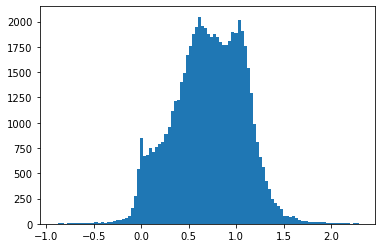

smb_beta


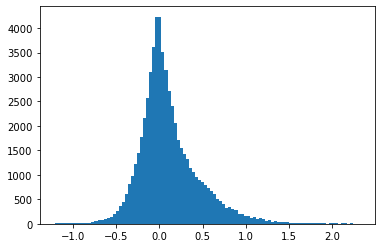

hml_beta


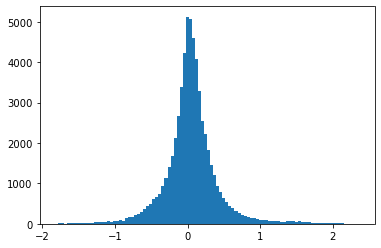

wml_beta


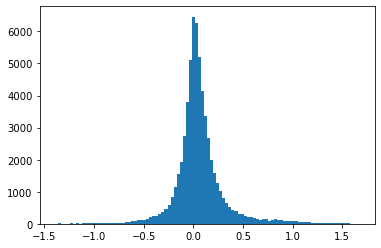

hml_fx_beta


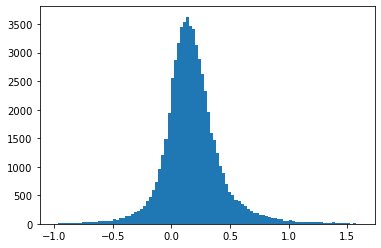

rx_beta


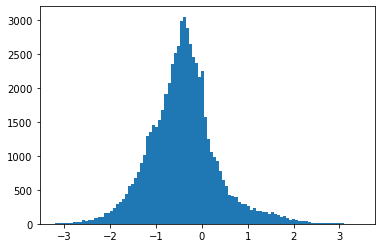

In [20]:
beta_hists(df_betas_lrv11)